## Scattered data interpolation via maximum entropy deconvolution

This notebook describes and compares several methods of scattered data interpolation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import Sampling
from gplusb import gplusm
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = [8., 8.]
dpi = 150

## Modelling the image with nonnegative constraints

The linear problem can be solved with non-negative constraints. This choice regularizes much of the bad behavior. With no (or very tiny) noise, the result is completely unchanged from the linear fit. Note that in this case, this result cannot be interpreted exactly as the "PSF" because the method is not linear.

In [2]:
sampling = Sampling(nsamples=1000)
sampling.set_flux(total_flux=1000., noise=0.001)

In [3]:
print(sampling.__dir__())

['nsamples', 'xylo', 'xyhi', 'sigmalo', 'sigmahi', 'x', 'y', 'sigma', 'nx', 'ny', 'xgrid', 'ygrid', 'A', 'flux_nonoise', 'flux', 'ivar', '__module__', '__init__', 'fluxes', 'set_flux', 'set_grid', 'Amatrix', 'imshow', '__dict__', '__weakref__', '__doc__', '__repr__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__eq__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [4]:
def mem_function(u, A, f, llambda):
    Ar = (A.dot(u) - f)
    As = (Ar**2).sum()
    Bs = (u * np.log(u)).sum()
    val =  As + llambda * Bs
    grad = 2. * A.T.dot(Ar) + llambda * (1. + np.log(u))
    return (val, grad)

def mem_fit(sampling, llambda=1.e-2):
    S_M0 = np.ones(sampling.nx * sampling.ny)
    bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
    bounds = [x for x in bounds]
    flux = sampling.flux
    results = optimize.minimize(mem_function, S_M0,
                                args=(sampling.A, flux, llambda),
                                method='L-BFGS-B', jac=True,
                                bounds=bounds) 
    return(results.x.reshape(sampling.nx, sampling.ny))


def mem_lambda_function(lnlambda, sampling):
    x = mem_fit(sampling, llambda=np.exp(lnlambda))
    recon = sampling.A.dot(x.flatten())
    chi2 = ((recon - sampling.flux)**2 * sampling.ivar).sum()
    val = chi2 - len(recon)
    print(val)
    return(val)


def mem_all(sampling):
    bracket = [np.log(1.e-5), np.log(1.e+16)]
    try:
        rootresults = optimize.root_scalar(mem_lambda_function,
                                           args=(sampling),
                                           method='brentq',
                                           bracket=bracket)
        lnl = rootresults.root
    except ValueError:
        if(mem_lambda_function(bracket[1], sampling) < 0.):
            lnl = bracket[1] 
        if(mem_lambda_function(bracket[0], sampling) > 0.):
            lnl = bracket[0]

    S_M = mem_fit(sampling, llambda=np.exp(lnl))
    print(np.exp(lnl))
    return(S_M)


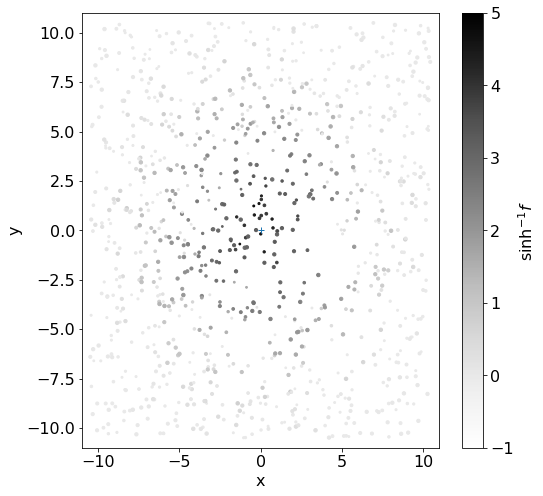

In [5]:
sampling.imshow()

-46.0358060948
37248210235.0
-46.0357604459
-45.7570271995
37248068198.6
-45.7570292934
1511928778.4
-45.7570523599
342377.469473
-45.9692592419
1963.23218165
-43.1338795756
15.1724225861
-14.1442125425
1.41330407041
-1.27066931304
1.60037471026
0.0709358122294
-0.184019647875
-1.04029992817
-0.199063719911
0.0436613438624
-0.158881490609
0.0375185819291
-0.14024140488
-0.0972284677451
-0.0941553019618
0.0375505667726
0.0360979675909
0.0361220790119
-0.0940739644309
-0.0940543436641
-0.0940217796042
0.0361213504156
-0.0940233198075
-0.0940418034527
-0.0940225407821
-0.0940381461139
2.74637228451e-05


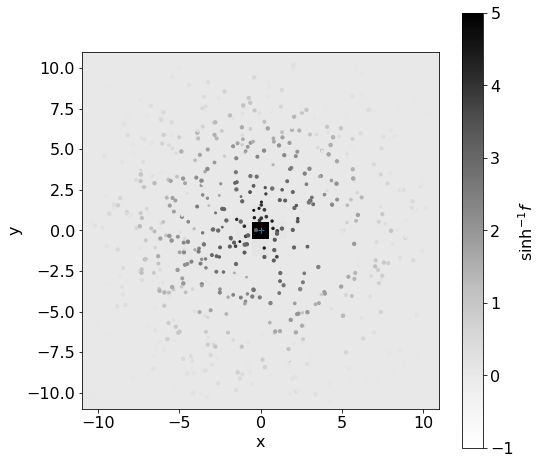

In [6]:
S_M = mem_all(sampling)
sampling.imshow(S_M)
plt.savefig('../tex/figures/scattered-mem-noiseless.png', dpi=dpi)

In [7]:
sampling = Sampling(nsamples=1000)
sampling.set_flux(total_flux=1000., noise=100.)

-15.8711260677
6.2607843914
6.26078438905
6.17299438347
-15.8699174709
3.18475260943
-12.6814502947
0.0225928772601
-0.00607625239354
0.00182729105677
-0.00283084889475
-0.00295086643803
0.00787693524694
-0.00186495400612
0.0074952106819
-0.00733972392209
0.00839343886537
0.00418611493615
0.00250111910486
-0.000116242471563
0.00273750844542
2.86692632017e-05
-2.21101468014e-05
-0.000623505723411
-3.35204281328e-05
0.000810161415984
0.000250472692983
19.3399776006


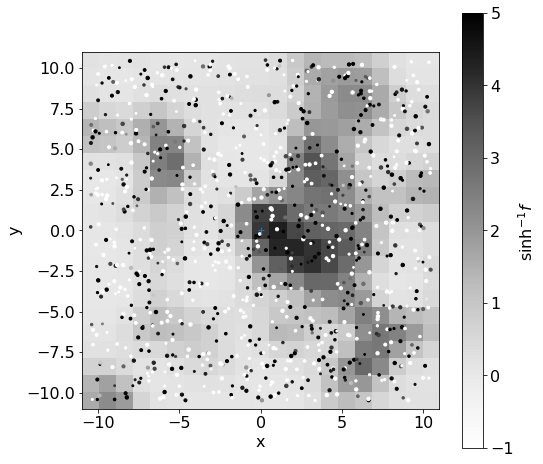

In [8]:
S_M = mem_all(sampling) 
sampling.imshow(S_M)
plt.savefig('../tex/figures/scattered-mem-noisy.png', dpi=dpi)

## PSF dependence on noise

In the absence of noise, the MEM result is the same as the linear result. Therefore, in that limited case it really does have a PSF. However, when noise is present, the response to a point source is changed. 

To study this we must consider the expectation value of the result over many realizations in the presence of noise. There are at least two things we learn from this: first, the profile of the response is affected by the noise level, and second, that the nonnegative constraints lead to a bias in the background level (since fluctuations above zero lead to a positive response but fluctuations below zero lead to a zero response).

In [9]:
def Sexpected(sampling, total_flux=1000., noise=10., nsample=5000,
              xcen=0., ycen=0.):
    Sarr = np.zeros((nsample, sampling.nx, sampling.ny))
    larr = np.zeros(nsample)
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen, ycen=ycen)
        Sarr[i, :, :] = mem_all(sampling)
    Sexp = Sarr.mean(axis=0)
    return(Sarr, Sexp)

In [10]:
Sarr_100, Sexp_100 = Sexpected(sampling, noise=100.)
fitsio.write('mem_sexp_100.fits', Sexp_100, clobber=True)
fitsio.write('mem_sexp_100.fits', Sarr_100, clobber=False)
Sexp_100 = fitsio.read('mem_sexp_100.fits', ext=0)
Sarr_100 = fitsio.read('mem_sexp_100.fits', ext=1)
sampling.imshow(Sexp_100, vmax=6.5, nopoints=True)
plt.savefig('../tex/figures/scattered-mem-mean-100.png', dpi=300)

40.9750993746
58.9608999554
58.9608999554
40.9750993746
1e-05
-1.85038295884
17.4590835628
-1.8503138425
17.4590778842
-1.85033316091
17.3429459103
-1.85014033529
-0.296148178779
2.81289123486
-0.121911219827


KeyboardInterrupt: 

In [ ]:
print(np.median(Sexp_100))

In [ ]:
(sigma, flux, background, model) = gplusm(sampling, Sexp_100)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_100 - model, vmax=6.5, nopoints=True)

In [ ]:
Sarr_30, Sexp_30 = Sexpected(sampling, noise=30.)
fitsio.write('mem_sexp_30.fits', Sexp_30, clobber=True)
fitsio.write('mem_sexp_30.fits', Sarr_30, clobber=False)
Sexp_30 = fitsio.read('mem_sexp_30.fits', ext=0)
Sarr_30 = fitsio.read('mem_sexp_30.fits', ext=1)
sampling.imshow(Sexp_30, nopoints=True)
plt.savefig('../tex/figures/scattered-mem-mean-30.png', dpi=dpi)

In [ ]:
(sigma, flux, background, model) = gplusm(sampling, Sexp_30)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_30 - model, vmax=6.5, nopoints=True)

In [ ]:
# Sarr_1, Sexp_1 = Sexpected(sampling, noise=1.)
# fitsio.write('mem_sexp_1.fits', Sexp_1, clobber=True)
# fitsio.write('mem_sexp_1.fits', Sarr_1, clobber=False)
Sexp_1 = fitsio.read('mem_sexp_1.fits', ext=0)
Sarr_1 = fitsio.read('mem_sexp_1.fits', ext=1)
sampling.imshow(Sexp_1, nopoints=True)
plt.savefig('../tex/figures/scattered-mem-mean-1.png', dpi=dpi)

In [ ]:
(sigma, flux, background, model) = gplusm(sampling, Sexp_1)
print("sigma = {sigma}".format(sigma=sigma))
print("flux = {flux}".format(flux=flux))
print("background = {background}".format(background=background))
sampling.imshow(Sexp_1 - model, vmax=6.5, nopoints=True)

In [ ]:
xg = sampling.xgrid.reshape(sampling.nx, sampling.ny)
plt.plot(xg[10, :], np.log10(Sexp_100[10, :]), color='black', label='noise = 100')
plt.plot(xg[10, :], np.log10(Sexp_30[10, :]), color='red', label='noise = 30')
plt.plot(xg[10, :], np.log10(Sexp_1[10, :]), color='blue', label='noise = 1')
plt.legend(fontsize=14, loc=1)
plt.xlabel('X')
plt.ylabel('$\log_{10}$ mean response')
plt.savefig('../tex/figures/scattered-mem-mean-slice.png', dpi=dpi)

## Nonlinearity (two point sources)

Because this method is not linear, you can't really think of the noiseless response as a PSF. For example, if you put in two point sources, the sum of their deconvolution is not the deconvolution of their sum. 

Because of the nature of NNLS, however, this only becomes apparent in the presence of noise. Without noise, the nonnegative constraints do not affect the fit, so things remain linear.

In [ ]:
sampling.set_flux(total_flux=1000., noise=0., xcen=0.0, ycen=0.0)
f1 = sampling.flux
f1_nonoise = sampling.flux_nonoise
sampling.set_flux(total_flux=1000., noise=1., xcen=1.0, ycen=1.0)
f2 = sampling.flux
f2_nonoise = sampling.flux_nonoise
f12 = f1 + f2
f12_nonoise = f1_nonoise + f2_nonoise

In [ ]:
sampling.flux = f1
sampling.flux_nonoise = f1_nonoise
S_M_1 = mem_fit(sampling)
sampling.imshow(S_M_1)

In [ ]:
sampling.flux = f2
sampling.flux_nonoise = f2_nonoise
S_M_2 = mem_fit(sampling)
sampling.imshow(S_M_2)

In [ ]:
sampling.flux = f12
sampling.flux_nonoise = f12_nonoise
S_M_12 = mem_fit(sampling)
sampling.imshow(S_M_12)

As for the dependence of the point source response on signal-to-noise ratio, we again need to look at the expectation value of the response using a Monte Carlo approach. 

In [ ]:
def Sexpected2(sampling, total_flux=1000., noise=1., nsample=3000,
               xcen1=0., ycen1=0., xcen2=1., ycen2=1.):
    Sarr1 = np.zeros((nsample, sampling.nx, sampling.ny))
    Sarr2 = np.zeros((nsample, sampling.nx, sampling.ny))
    Sarr12 = np.zeros((nsample, sampling.nx, sampling.ny))
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen1, ycen=ycen1)
        f1 = sampling.flux
        Sarr1[i, :, :] = mem_fit(sampling)
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen2, ycen=ycen2)
        f2 = sampling.flux
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr2[i, :, :] = mem_fit(sampling)
        sampling.flux = f1 + f2
        x = optimize.nnls(sampling.A, sampling.flux)
        Sarr12[i, :, :] = mem_fit(sampling)
    Sexp1 = Sarr1.mean(axis=0)
    Sexp2 = Sarr2.mean(axis=0)
    Sexp12 = Sarr12.mean(axis=0)
    return(Sarr1, Sexp1, Sarr2, Sexp2, Sarr12, Sexp12)

In [ ]:
(Sarr1, Sexp1, Sarr2, Sexp2, Sarr12, Sexp12) = Sexpected2(sampling, noise=30.)

In [ ]:
sampling.imshow((((Sexp1 + Sexp2) - (Sexp12)) / Sexp12.max()) , vmin=-0.2, vmax=0.2)
print((((Sexp1 + Sexp2) - (Sexp12)) / Sexp12.max()).min())

## Diffuse sources

The nonlinearity found above implies that this method may behave differently for point sources versus extended sources. A simple test to consider is simply a flat uniform background. How does the algorithm behave in that case?

In [ ]:
sampling = Sampling(nsamples=1000, sigmarange=[1., 4.])
flat = np.ones(sampling.A.shape[1]) * 1000.
sampling.set_flux(total_flux=0., noise=10.)
sampling.flux = sampling.flux + sampling.A.dot(flat)
sampling.flux_nonoise = sampling.flux_nonoise + sampling.A.dot(flat)

In the case of no noise, obviously it works great.

In [ ]:
S_M = mem_fit(sampling, llambda=1.e-2, nonoise=True)
sampling.imshow(S_M)

But in the presence of noise, the degeneracies arise. Basically, just like in the linear case, neighboring pixels can trade off their flux in many cases. The $\lambda$ parameter controls this degeneracy.

In [ ]:
S_M = mem_fit(sampling, llambda=1.e-4)
sampling.imshow(S_M)
plt.savefig('../tex/figures/scattered-mem-flat.png', dpi=dpi)

In [ ]:
S_M = mem_fit(sampling, llambda=1.e-2)
sampling.imshow(S_M)
plt.savefig('../tex/figures/scattered-mem-flat.png', dpi=dpi)

In [ ]:
def SexpectedFlat(sampling, total_flux=0., noise=10., nsample=1000,
              xcen=0., ycen=0., flat_flux=1000.):
    flat = np.ones(sampling.A.shape[1]) * flat_flux
    Sarr = np.zeros((nsample, sampling.nx, sampling.ny))
    for i in np.arange(nsample):
        sampling.set_flux(total_flux=total_flux, noise=noise, xcen=xcen, ycen=ycen)
        sampling.flux = sampling.flux + sampling.A.dot(flat)
        sampling.flux_nonoise = sampling.flux_nonoise + sampling.A.dot(flat)
        Sarr[i, :, :] = mem_fit(sampling)
    Sexp = Sarr.mean(axis=0)
    return(Sarr, Sexp)

In [ ]:
# SarrFlat, SexpFlat = SexpectedFlat(sampling)

In [ ]:
fitsio.write('mem_sexpflat.fits', SexpFlat, clobber=True)
fitsio.write('mem_sexpflat.fits', SarrFlat, clobber=False)

In [ ]:
SexpFlat = fitsio.read('mem_sexpflat.fits', ext=0)
SarrFlat = fitsio.read('mem_sexpflat.fits', ext=1)

In [ ]:
SarrFlatFlat = SarrFlat.reshape(SarrFlat.shape[0], sampling.nx * sampling.ny)
C_M = np.zeros((sampling.nx * sampling.ny, sampling.nx * sampling.ny))
for i in np.arange(sampling.nx * sampling.ny):
    for j in np.arange(sampling.nx * sampling.ny):
        C_M[i, j] = (((SarrFlatFlat[:, i] - SarrFlatFlat[:, i].mean()) *
                      (SarrFlatFlat[:, j] - SarrFlatFlat[:, j].mean())).sum() /
                      np.float32(sampling.nsamples))

In [ ]:
CC_M = 0. * C_M
for i in np.arange(sampling.nx * sampling.ny):
    for j in np.arange(sampling.nx * sampling.ny):
        CC_M[i, j] = C_M[i, j] / np.sqrt(C_M[i, i] * C_M[j, j])

In [ ]:
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
plt.imshow(CC_M, vmin=-1.0, vmax=1., **myargs)
nmid = (sampling.nx * sampling.ny) // 2
plt.xlim([nmid - 20, nmid + 20])
plt.ylim([nmid - 20, nmid + 20])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')
plt.savefig('../tex/figures/scattered-mem-flat-covar.png', dpi=dpi)

In [ ]:
for i in np.arange(sampling.nx - 4) + 2:
    for j in np.arange(sampling.nx - 4) + 2:
        xran = np.random.normal(size=SarrFlat.shape[0]) * 20.
        yran = np.random.normal(size=SarrFlat.shape[0]) * 20.
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i, j + 1] + yran, s=1, alpha=0.003, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i, j - 1] + yran, s=1, alpha=0.003, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i + 1, j] + yran, s=1, alpha=0.003, color='black')
        plt.scatter(SarrFlat[:, i, j] + xran, SarrFlat[:, i - 1, j] + yran, s=1, alpha=0.003, color='black')
plt.xlabel('flux in pixel $i$')
plt.ylabel('flux in pixel $j$')
plt.savefig('../tex/figures/scattered-mem-flat-dist-joint.png', dpi=dpi)

In [ ]:
SarrVals = SarrFlat[:, 2:-2, 2:-2].flatten()

In [ ]:
vals, edges = np.histogram(SarrVals, bins=100, range=[-1., 7500.])
hx = np.zeros(2 * (len(vals) - 2) + 2)
hv = np.zeros(2 * (len(vals) - 2) + 2)
hx[0] = edges[0] 
hv[0] = vals[0] 
for i in np.arange(len(vals) - 2):
    hx[2 * i + 1] = edges[i + 1]
    hv[2 * i + 1] = vals[i]
    hx[2 * i + 2] = edges[i + 1]
    hv[2 * i + 2] = vals[i + 1]
hx[-1] = edges[-1]
hv[-1] = vals[-1]
dx = edges[1] - edges[0]
hv = hv / dx

In [ ]:
plt.plot(hx, (hv))
plt.xlabel('Pixel value')
plt.ylabel('$\log_{10} P_{\mathrm{pixel}}$')
plt.savefig('../tex/figures/scattered-mem-flat-dist.png', dpi=dpi)

In [ ]:
print(np.arcsinh(100))